Generating libraries


In [1]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real


In [2]:
# difinning the no of grid points in x, y and z
Nx = 128 # number of grid points in x be positive even integer number
Ny = 128 # number of grid points in y be positive even integer number
Nz = 128 # number of grid points in z be positive even integer number


2d allen cahn equations

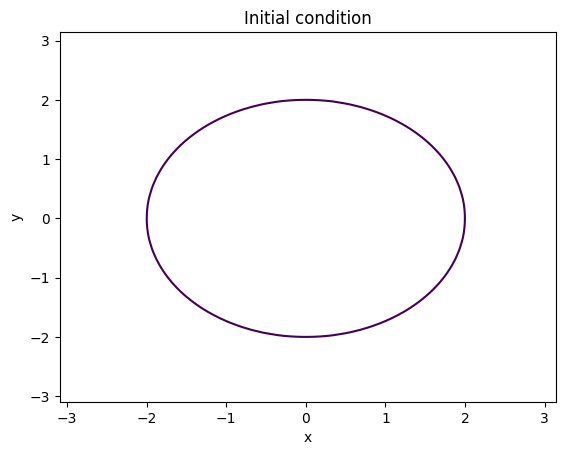

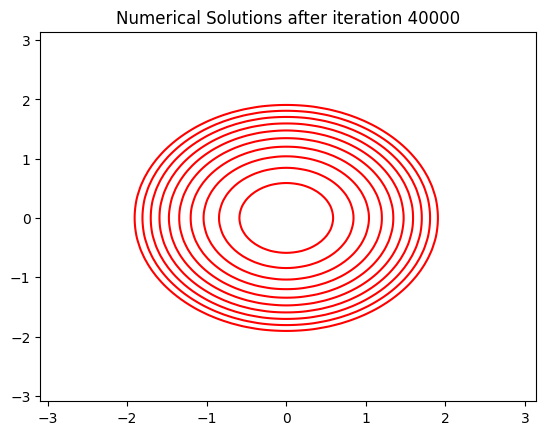

In [3]:
# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 20 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
epsillon = 0.05 #small parameter
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
u =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation

# defining the wavenumber in x and y direction
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2 , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2) # creating meshgrid in x and y direction for square of wavenumber


# plotting the initial condition of the Allen-Cahn equation
figure1 = plt.figure()
plt.contour(x, y, jnp.real(u.T), [0])
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# prviding the range of iteration
for iter in range(1, Nt):
    u = jnp.real(u)

    # transforming the solution to the Fourier space
    s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u))
    v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))
    u = jfft.ifft2(v_hat)
    if iter % ns == 0:
        plt.contour(x, y, jnp.real(u.T), [0], colors='red')
        
plt.title('Numerical Solutions after iteration '+str(Nt))
plt.show()
       


3d of AC equation

Min value: (-1.0000481605529785-1.1460026172471771e-07j), Max value: (1.0000481605529785+1.0856851417884172e-07j)


c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\skimage\measure\_marching_cubes_lewiner.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  volume = np.ascontiguousarray(volume, np.float32)  # no copy if not necessary


Min value: (-1.0000556707382202-1.3627555972561822e-08j), Max value: (1.0000516176223755-4.888460836127706e-08j)
Min value: (-1.0000481605529785+8.5674741967523e-08j), Max value: (1.0000518560409546-9.560235980643483e-08j)
Min value: (-1.0000606775283813+1.5652236129426456e-07j), Max value: (1.0000474452972412+1.499324326914575e-07j)
Min value: (-1.0000542402267456+1.6938416536049772e-07j), Max value: (1.0000375509262085+6.61599628415388e-08j)
Min value: (-1.000044345855713-7.523360068262264e-08j), Max value: (1.0000340938568115+1.1814092459871972e-07j)
Min value: (-1.000051736831665+2.9680208513127582e-08j), Max value: (1.0000351667404175-5.2950742457369415e-08j)
Min value: (-1.0000454187393188+1.676153260632418e-08j), Max value: (1.0000345706939697-3.014189786654242e-08j)
Min value: (-1.000051736831665-1.6092911891973927e-08j), Max value: (1.0000325441360474+5.218337761903058e-09j)


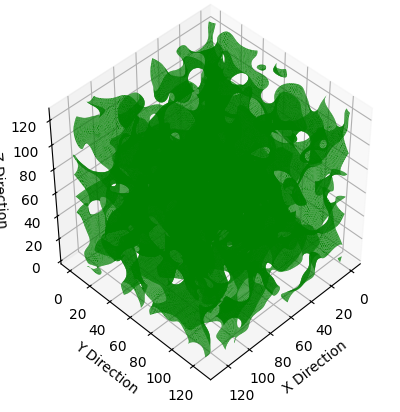

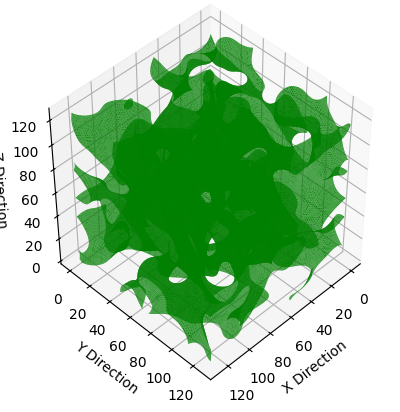

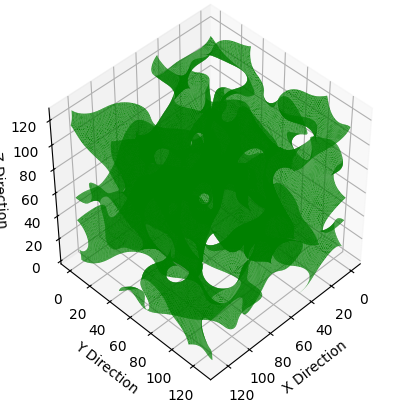

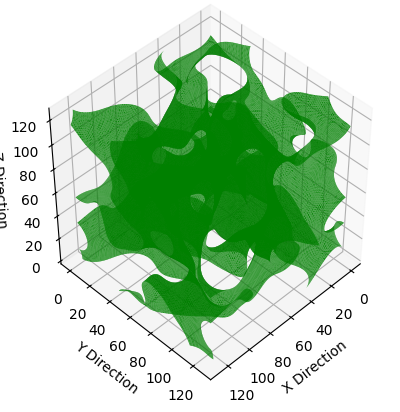

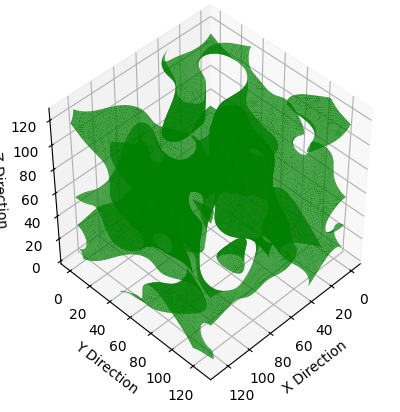

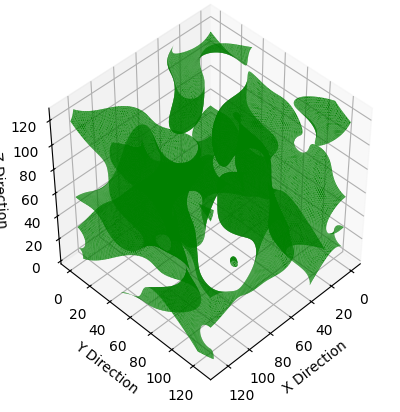

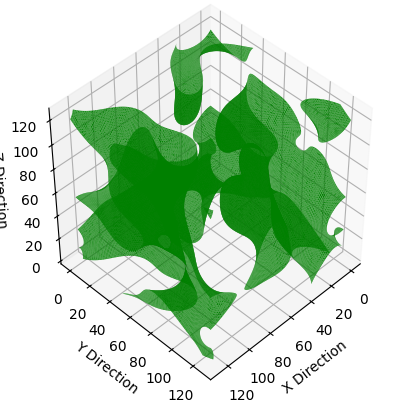

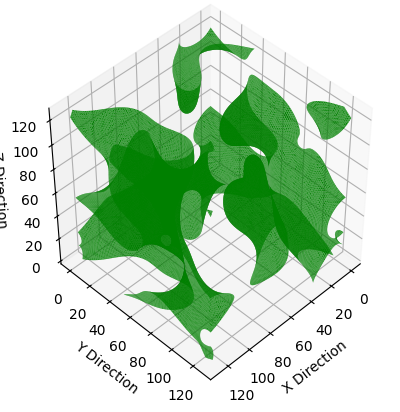

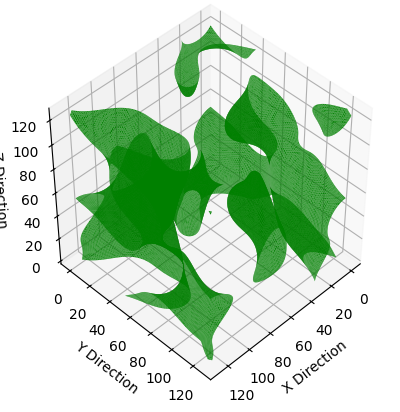

In [4]:

# defining parameter for 3d allen cahn

Lx = 1.2  #length of the domain in x
Ly = 1.2  #length of the domain in y
Lz = 1.2  
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
hz = Lz / Nz
dt = 0.001 #time step size
T = 0.5 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots


# defining the function of (x,y,z) direction
def x_gridpoint_3d(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint_3d(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
# print(x.shape)

def y_gridpoint_3d(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint_3d(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis
# print(y.shape) 

def z_gridpoint_3d(Nz, Lz, hz):
    z = jnp.linspace(-0.5*Lz+hz,0.5*Lz,Nz)
    return z

z = z_gridpoint_3d(Nz, Lz, hz) #number of grid points in z direction and step size and limitation on z  axis
# print(z.shape)

# creating the meshgrid in x, y, and z direction

xx, yy, zz = jnp.meshgrid(x, y, z) #creating meshgrid in x, y, and z direction 
# print(xx.shape , yy.shape, zz.shape)

# defining the small parameter and cahn number

epsillon = hx #small parameter
cahn = epsillon**2 #cahn number 


# initial condition of allen cahn equation in 3D
u = np.random.rand(Nx, Ny, Nz)- 0.5 #initial condition of allen cahn equation

# defining the wavenumber in x, y, and z direction
kx = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2 , 0)]) # wavenumber in x direction
ky = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)]) # wavenumber in y direction
kz = jnp.concatenate([2 * jnp.pi / Lz * jnp.arange(0, Nz//2), 2 * jnp.pi / Lz * jnp.arange(-Nz//2 , 0)]) # wavenumber in z direction

# square of wavenumber in x, y, and z direction
k2x = kx**2 # square of wavenumber in x direction
k2y = ky**2 # square of wavenumber in y direction
k2z = kz**2 # square of wavenumber in z direction

# creating meshgrid in x, y, and z direction for square of wavenumber
kxx, kyy, kzz = jnp.meshgrid(k2x, k2y, k2z, indexing= 'ij') # creating meshgrid in x, y, and z direction for square of wavenumber


# Visualize the initial condition
u_numpy = np.array(u)  # Convert JAX array to NumPy array


#simulation loop for 3D Allen-Cahn equation
for iter in range(1, Nt):
    # Real part of the solution
    u = jnp.real(u)
    
    # Fourier transform of the solution
    s_hat = jfft.fftn(cahn * u - dt * (u**3 - 3 * u))
    v_hat = s_hat / (cahn + dt * (2 + cahn * (kxx + kyy + kzz)))
    u = jfft.ifftn(v_hat)  #inversre the fourier space to the real space

 
    
    if iter % ns == 0:
        u_numpy = np.array(u)  # Convert JAX array to numpy array
        min_val, max_val = np.min(u_numpy), np.max(u_numpy)
        print(f"Min value: {min_val}, Max value: {max_val}")
        if min_val < 0 < max_val:
            verts, faces, _, _ = measure.marching_cubes(u_numpy, level=0)
            p1 = Poly3DCollection(verts[faces], facecolor='g', edgecolor='none')
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.add_collection3d(p1)
            ax.set_box_aspect([1,1,1])
            ax.view_init(elev=45, azim=45)
            ax.set_xlabel('X Direction')
            ax.set_ylabel('Y Direction')
            ax.set_zlabel('Z Direction')

plt.show()
            